
# 3.4 softmax回归
引入：前面所学线性回归一般用于预测**多少**的问题，但有时我们将遇到分类的问题，即预测**属于那一类**。  
例如“某个图像描绘的是狗、猫、鸡？”即是一个分类问题。深度学习中解决分类问题所用模型为softmax回归。

## 3.4.1 分类问题
如上述狗、猫、鸡分类问题，可用独热编码表示三种情况：

独热编码(one-hot encoding),可类比多元逻辑回归模型：
$$y \in {\{(1,0,0),(0,1,0),(0,0,1)\}}$$
分别对应狗、猫、鸡三类。
## 3.4.2 网络框架
类比多响应逻辑回归模型，估计所有可能类别的条件概率，需要有多个输出，模型如下，为单层神经网络模型，计算三个未规范化的预测：
$$o_1=x_1w_{11}+x_2w_{12}+x_3w_{13}+x_4w_{14}+b_1$$
$$o_2=x_1w_{21}+x_2w_{22}+x_3w_{23}+x_4w_{24}+b_2$$
$$o_3=x_1w_{31}+x_2w_{32}+x_3w_{33}+x_4w_{34}+b_3$$

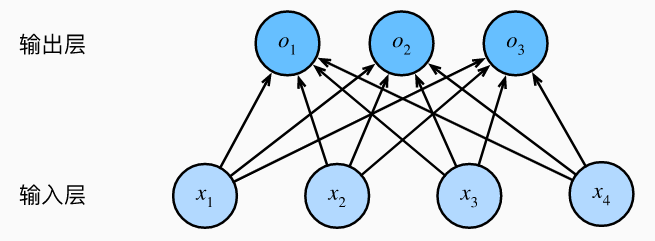
$$\boldsymbol{o}=\boldsymbol{Wx+b}$$

## 3.4.3 softmax运算
$$\hat{\boldsymbol{y}}=softmax(\boldsymbol{o}),\hat{y}_j=\frac{\text{exp}(o_j)}{\sum_k\text{exp}(o_k)}$$
 
 $$\mathop{\arg\min}\limits_{j} \hat{y}_j=\mathop{\arg\min}\limits_{j} o_j$$
 
 ## 3.4.4 损失函数
 #### 3.4.4.1 对数似然
假设整个数据集${\boldsymbol{X},\boldsymbol{Y}}$具有n个样本， 其中索引$i$的样本由特征向量$\boldsymbol{x}^{(i)}$和独热标签向量$\boldsymbol{y}^{(i)}$组成。 我们可以将估计值与实际值进行比较：
$$P(\boldsymbol{Y}|\boldsymbol{X})=\prod \limits_{i=0}^n P(\boldsymbol{y}^{(i)}|\boldsymbol{x}^{(i)})$$

根据最大似然估计，最大化$P(\boldsymbol{Y}|\boldsymbol{X})$相当于最小化负对数似然：
$$-\text{log} P(\boldsymbol{Y}|\boldsymbol{X})=\sum_{i=1}^n -\text{log}P(\boldsymbol{y}^{(i)}|\boldsymbol{x}^{(i)})=\sum_{i=1}^n l(\boldsymbol{y}^{(i)},\boldsymbol{\hat{y}}^{(i)})$$
 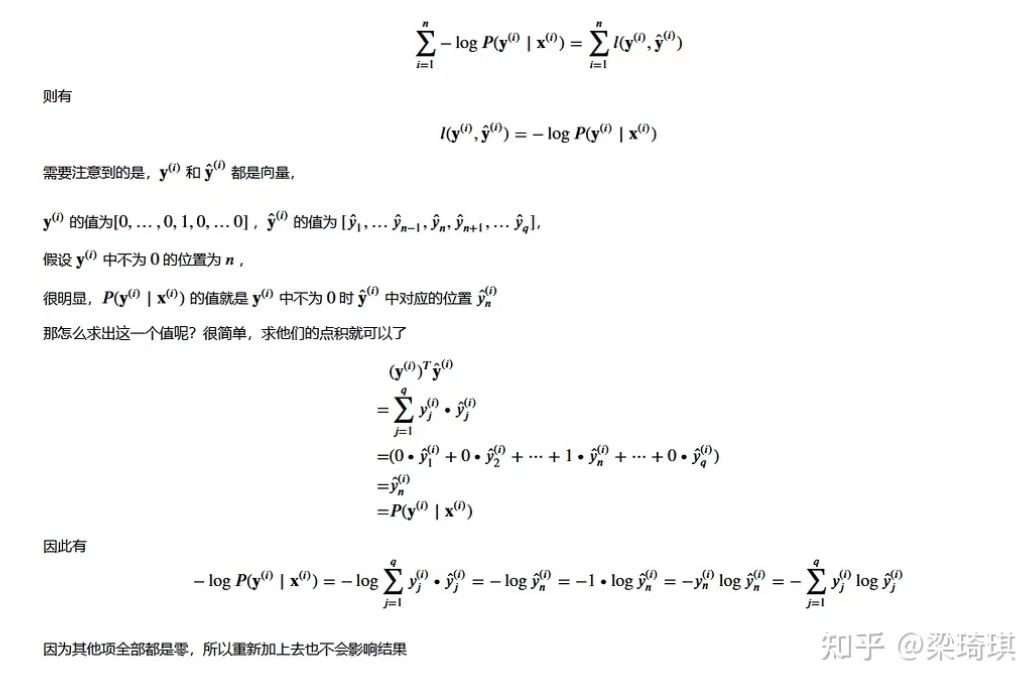
 #### 3.4.4.2 softmax及其导数
 $$l(\boldsymbol{y},\boldsymbol{\hat{y}})=-\sum_{j=1}^q y_i \text{log}\frac{\text{exp}(o_j)}{\sum_{k=1}^q \text{exp}(o_k)}=\sum_{j=1}^q y_j\text{log}\sum_{k=1}^q \text{exp}(o_k)-\sum_{j=1}^q y_jo_j=\text{log}\sum_{k=1}^q \text{exp}(o_k)-\sum_{j=1}^q y_jo_j$$
 
   
 $$\partial_{oj}l(\boldsymbol{y},\boldsymbol{\hat{y}})=\text{softmax}(\boldsymbol{o})_j-y_j$$  
 
 导数是softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异。
 # 3.5 图像分类数据集

In [2]:
%matplotlib inline
import torch
import torchvision #处理图像视频的工具集
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

## 3.5.1 读取数据集

**pytorch中图像数据的shape由四个数字组成shape(Batch_size,通道数,高度,宽度)**

In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
## 分类标签
def get_fashion_mnist_labels(labels): 
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)#figsize设置子图的大小
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):#zip合并，enumerate返回字典
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

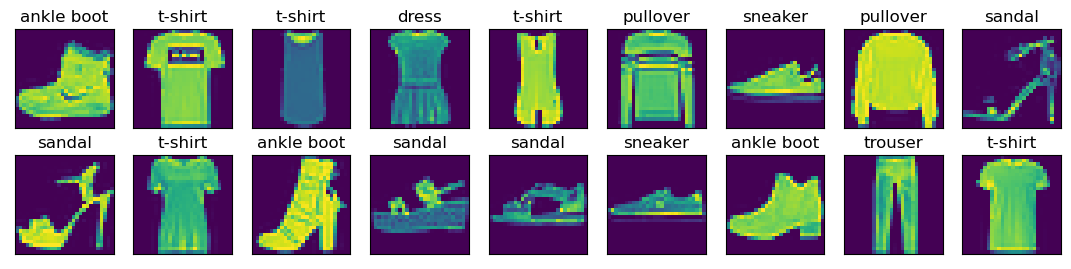

In [10]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [ ]:
mnist_train[0][0].shape

## 3.5.2 读取小批量

In [11]:
batch_size = 256

def get_dataloader_workers(): 
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())#读取4次，一共256×4张图片

## 3.5.3 整合所有组件
**此处的resize改变图像的高度和宽度，即shape的第3和第4的参数。

In [12]:
def load_data_fashion_mnist(batch_size, resize=None): 
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))#在索引0处插入
    trans = transforms.Compose(trans)#组合几种变换方式，按顺序变换相应数据
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [13]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 3.6 softmax回归的从零开始实现

In [15]:
import torch
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)#读取4次，一共256×4张图片

# 3.6.1 初始化模型参数
**原始数据集中的每个样本都是的图像。 在本节中，我们将展平每个图像，把它们看作长度为784的向量。**
因为我们的数据集有10个类别，所以网络输出维度为10。 因此，权重将构成一个784×10的矩阵， 偏置将构成一个1×10的行向量。

维度变化为：1×784×784×10+1×10

In [16]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# 3.6.2 定义softmax操作

In [17]:
#例子
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [18]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [19]:
#例子
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0725, 0.1103, 0.0793, 0.3617, 0.3762],
         [0.3478, 0.0529, 0.4368, 0.0806, 0.0819]]),
 tensor([1., 1.]))

# 3.6.3 定义模型

In [20]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)
#将一个样本28×28展平为784维的向量

# 3.6.4 定义损失函数

In [21]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

#例子
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

# 3.6.5 分类精度
**预测正确的个数/总预测数**

In [22]:
def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)#给出最大的值所在索引
    cmp = y_hat.type(y.dtype) == y #避免格式的不同
    return float(cmp.type(y.dtype).sum())

#例子
accuracy(y_hat, y) / len(y)

0.5

In [23]:
# 进阶版
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): 
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):#判断net是否属于torch.nn.Module，考虑继承关系
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())#numel读取数组元素的个数
    return metric[0] / metric[1]

#例子
evaluate_accuracy(net, test_iter)

0.0641

# 3.6.6 训练模型

In [24]:
#更新参数函数
def train_epoch_ch3(net, train_iter, loss, updater): 
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [35]:
from matplotlib_inline import backend_inline
def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')

    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
#动态图像
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [36]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
#assert：为False时触发异常

In [37]:
lr = 0.1

#线性回归时所用更新参数的函数
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

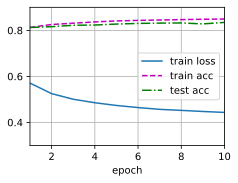

In [38]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# 3.6.7 预测

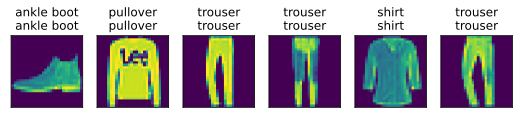

In [40]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)